In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
#from rpy2.robjects import r, pandas2ri

In [2]:
q = '''
SELECT
  DISTINCT chemical_code,
  chemical,
  para,
  month,
  chem_items,
  para_items
FROM (
  SELECT
    SUBSTR(bnf_code, 0, 9) AS chem_code_presc,
    month,
    SUM(items) AS chem_items
  FROM
    hscic.normalised_prescribing_standard
  GROUP BY
    chem_code_presc,
    month)
LEFT JOIN (
  SELECT
    SUBSTR(bnf_code, 0, 6) AS para_code,
    month AS para_month,
    SUM(items) AS para_items
  FROM
    hscic.normalised_prescribing_standard
  GROUP BY
    para_code,
    month)
ON
  SUBSTR(chem_code_presc, 0, 6) = para_code
  AND para_month = month
LEFT JOIN
  hscic.bnf
ON
  chemical_code = chem_code_presc
WHERE
  chemical_code IS NOT NULL
ORDER BY
  chemical_code,
  month
'''

chem_para_ratio = pd.read_gbq(q, dialect='standard', project_id = 'ebmdatalab')
chem_para_ratio.head()

,chemical_code,chemical,para,month,chem_items,para_items
0,210109007,DUMMY CHEMICAL SUBSTANCE 210109007,DUMMY PARAGRAPH 210109,2010-12-01,112707,468893
1,210109007,DUMMY CHEMICAL SUBSTANCE 210109007,DUMMY PARAGRAPH 210109,2011-01-01,100306,427871
2,210109007,DUMMY CHEMICAL SUBSTANCE 210109007,DUMMY PARAGRAPH 210109,2011-02-01,96705,414840
3,210109007,DUMMY CHEMICAL SUBSTANCE 210109007,DUMMY PARAGRAPH 210109,2011-03-01,109879,472643
4,210109007,DUMMY CHEMICAL SUBSTANCE 210109007,DUMMY PARAGRAPH 210109,2011-04-01,97961,417744


In [29]:
chem_para = chem_para_ratio.copy()
chem_para = chem_para.sort_values(['chemical_code','month'])
chem_para['ratio'] = chem_para['chem_items'] / chem_para['para_items']
chem_para['chemical_code'] = 'ratio_quantity.' + chem_para['chemical_code'] ## R code wants col headers in this format
#chem_para = chem_para.head(10000)
chem_para = chem_para.drop(['chemical','para'],axis=1)
chem_para = chem_para.set_index(['month','chemical_code'])

## drop small numbers
mask = (chem_para['chem_items'] > 50) & (chem_para['para_items']> 1000)
chem_para = chem_para.loc[mask]
chem_para = chem_para.drop(columns=['chem_items','para_items'])

## unstack
chem_para = chem_para.unstack().reset_index(col_level=1)
chem_para.columns = chem_para.columns.droplevel()
chem_para['month'] = pd.to_datetime(chem_para['month'])
chem_para = chem_para.set_index('month')

## dropna to remove chems with missing values
chem_para = chem_para.dropna(axis=1)

## drop cols with all identical values
cols = chem_para.select_dtypes([np.number]).columns
std = chem_para[cols].std()
cols_to_drop = std[std==0].index
chem_para = chem_para.drop(cols_to_drop, axis=1)

## out to csv
chem_para.to_csv('data.pick.csv', index=False)
chem_para

chemical_code,ratio_quantity.0101010C0,ratio_quantity.0101010G0,ratio_quantity.0101010I0,ratio_quantity.0101010J0,ratio_quantity.0101010L0,ratio_quantity.0101010R0,ratio_quantity.0101012B0,ratio_quantity.010102100,ratio_quantity.0101021B0,ratio_quantity.0101021C0,...,ratio_quantity.239410099,ratio_quantity.239448094,ratio_quantity.239448095,ratio_quantity.239448096,ratio_quantity.239448097,ratio_quantity.239448098,ratio_quantity.239448099,ratio_quantity.239601096,ratio_quantity.239601097,ratio_quantity.239610096
month,,,,,,,,,,,,,,,,,,,,,
2010-08-01,0.027128,0.376444,0.010714,0.092553,0.155129,0.242819,0.016717,0.000490,0.998873,0.000638,...,0.191231,0.282884,0.297604,0.222831,0.087692,0.064908,0.044081,0.262833,0.729563,1.000000
2010-09-01,0.029042,0.373462,0.010407,0.090570,0.152732,0.243126,0.019619,0.000576,0.998789,0.000635,...,0.199918,0.278077,0.289778,0.237525,0.088837,0.061735,0.044048,0.214064,0.772837,1.000000
2010-10-01,0.026409,0.380408,0.010232,0.089685,0.158077,0.237943,0.018057,0.000559,0.998841,0.000600,...,0.197391,0.271669,0.295096,0.235547,0.088944,0.064460,0.044283,0.216093,0.772294,1.000000
2010-11-01,0.027662,0.375522,0.011670,0.090889,0.153710,0.238505,0.029693,0.000551,0.998880,0.000569,...,0.206223,0.281624,0.287279,0.233732,0.091631,0.061350,0.044384,0.234411,0.751347,1.000000
2010-12-01,0.027840,0.385523,0.011062,0.096993,0.162324,0.219785,0.022680,0.000489,0.998907,0.000604,...,0.195116,0.283924,0.298804,0.237363,0.082087,0.057240,0.040581,0.248744,0.734925,1.000000
2011-01-01,0.026604,0.372495,0.012428,0.096046,0.156206,0.244252,0.020157,0.000467,0.998937,0.000596,...,0.214105,0.284021,0.289661,0.232366,0.087209,0.059992,0.046751,0.221831,0.759243,1.000000
2011-02-01,0.027360,0.372101,0.011067,0.093311,0.156076,0.250163,0.020745,0.000560,0.998810,0.000630,...,0.215283,0.279475,0.289516,0.231612,0.090620,0.062254,0.046523,0.207759,0.768534,1.000000
2011-03-01,0.026800,0.367639,0.010144,0.092989,0.157416,0.251196,0.020001,0.000462,0.998883,0.000655,...,0.216836,0.279234,0.292227,0.231940,0.089984,0.060212,0.046403,0.203782,0.775762,1.000000
2011-04-01,0.028388,0.372897,0.010276,0.092271,0.162406,0.236052,0.021066,0.000530,0.998919,0.000551,...,0.222829,0.280809,0.294474,0.230822,0.086396,0.063219,0.044279,0.210575,0.763451,1.000000


In [19]:
q = '''
SELECT
  DISTINCT chemical_code,
  chemical,
  para,
  i.month,
  chem_items,
  list_size
FROM (
  SELECT
    SUBSTR(bnf_code, 0, 9) AS chem_code_presc,
    month,
    SUM(items) AS chem_items
  FROM
    hscic.normalised_prescribing_standard
  GROUP BY
    chem_code_presc,
    month) AS i
LEFT JOIN (
  SELECT
    month,
    SUM(total_list_size) AS list_size
  FROM
    hscic.practice_statistics_all_years
  GROUP BY
    month) AS s
ON
  i.month = s.month
LEFT JOIN
  hscic.bnf
ON
  chemical_code = chem_code_presc
WHERE
  chemical_code IS NOT NULL
  AND list_size IS NOT NULL
ORDER BY
  chemical_code,
  month
'''

chem_pop_ratio = pd.read_gbq(q, dialect='standard', project_id = 'ebmdatalab')
chem_pop_ratio.head()

,chemical_code,chemical,para,month,chem_items,list_size
0,210400002,DUMMY CHEMICAL SUBSTANCE 210400002,DUMMY PARAGRAPH 210400,2017-03-01,3966,58171599
1,210400002,DUMMY CHEMICAL SUBSTANCE 210400002,DUMMY PARAGRAPH 210400,2017-04-01,2876,58328549
2,210400002,DUMMY CHEMICAL SUBSTANCE 210400002,DUMMY PARAGRAPH 210400,2017-05-01,3458,58364158
3,210400002,DUMMY CHEMICAL SUBSTANCE 210400002,DUMMY PARAGRAPH 210400,2017-06-01,3406,58437363
4,210400002,DUMMY CHEMICAL SUBSTANCE 210400002,DUMMY PARAGRAPH 210400,2017-07-01,3384,58492541


In [15]:
chem_pop = chem_pop_ratio.copy()
chem_pop = chem_pop.sort_values(['chemical_code','month'])
chem_pop['ratio'] = chem_pop['chem_items'] / (chem_pop['list_size'] / 1000)
chem_pop['chemical_code'] = 'ratio_quantity.' + chem_pop['chemical_code'] #added as the R code wants it in this format
#chem_pop = chem_pop.head(10000)
chem_pop = chem_pop.drop(['chemical','para'],axis=1)
chem_pop = chem_pop.set_index(['month','chemical_code'])

## drop small numbers
mask = (chem_pop['chem_items'] > 50)
chem_pop = chem_pop.loc[mask]
chem_pop = chem_pop.drop(columns=['chem_items','list_size'])

## unstack
chem_pop = chem_pop.unstack().reset_index(col_level=1)
chem_pop.columns = chem_pop.columns.droplevel()
chem_pop['month'] = pd.to_datetime(chem_pop['month'])
chem_pop = chem_pop.set_index('month')

## dropna to remove chems with missing values
chem_pop = chem_pop.dropna(axis=1)

## drop cols with all identical values
cols = chem_pop.select_dtypes([np.number]).columns
std = chem_pop[cols].std()
cols_to_drop = std[std==0].index
chem_pop = chem_pop.drop(cols_to_drop, axis=1)

## out to csv
#chem_pop.to_csv('data.pick.csv', index=False)
chem_pop

chemical_code,ratio_quantity.0101010C0,ratio_quantity.0101010F0,ratio_quantity.0101010G0,ratio_quantity.0101010I0,ratio_quantity.0101010J0,ratio_quantity.0101010L0,ratio_quantity.0101010N0,ratio_quantity.0101010P0,ratio_quantity.0101010Q0,ratio_quantity.0101010R0,...,ratio_quantity.239607096,ratio_quantity.239610096,ratio_quantity.239610097,ratio_quantity.239633596,ratio_quantity.239634596,ratio_quantity.239641096,ratio_quantity.239641097,ratio_quantity.239648096,ratio_quantity.239656096,ratio_quantity.239659096
month,,,,,,,,,,,,,,,,,,,,,
2010-10-01,0.012713,0.001159,0.183127,0.004926,0.043174,0.076098,0.000000,0.028885,0.003133,0.114545,...,0.013908,0.025970,0.000000,0.003513,0.011482,0.003894,0.005922,0.006121,0.007081,0.000000
2010-11-01,0.013564,0.001268,0.184142,0.005723,0.044568,0.075373,0.000000,0.030461,0.003260,0.116954,...,0.014253,0.027274,0.000000,0.003550,0.012224,0.003966,0.005850,0.007498,0.007552,0.000000
2010-12-01,0.013582,0.001068,0.188090,0.005397,0.047321,0.079195,0.000000,0.031457,0.002861,0.107229,...,0.013220,0.028759,0.000000,0.003260,0.012116,0.004020,0.005886,0.006266,0.008584,0.000000
2011-01-01,0.012397,0.001303,0.173572,0.005791,0.044755,0.072788,0.000000,0.028811,0.002715,0.113814,...,0.012361,0.027997,0.000000,0.003221,0.011076,0.003601,0.006352,0.005628,0.007221,0.000000
2011-02-01,0.012125,0.000000,0.164903,0.004904,0.041352,0.069168,0.000000,0.026368,0.002769,0.110864,...,0.013609,0.026332,0.000000,0.003185,0.010877,0.003674,0.005465,0.006316,0.008053,0.000000
2011-03-01,0.013483,0.001375,0.184955,0.005103,0.046782,0.079194,0.001267,0.030186,0.003619,0.126374,...,0.014188,0.028540,0.000000,0.003276,0.011854,0.003927,0.006352,0.006551,0.009338,0.000000
2011-04-01,0.011996,0.001285,0.157578,0.004342,0.038992,0.068629,0.001122,0.026326,0.003022,0.099751,...,0.011634,0.027593,0.000000,0.003004,0.009952,0.001592,0.005627,0.005048,0.008142,0.000000
2011-05-01,0.013100,0.001393,0.174044,0.004505,0.042719,0.071362,0.001339,0.027665,0.003166,0.114153,...,0.015796,0.028100,0.000000,0.003474,0.012611,0.002026,0.008432,0.006731,0.009119,0.000000
2011-06-01,0.013552,0.001484,0.177518,0.005301,0.045325,0.072664,0.001647,0.027683,0.003420,0.118261,...,0.013625,0.028715,0.000000,0.003763,0.012467,0.001791,0.008956,0.006333,0.009264,0.000000


In [15]:
class get_data():
    def shape_dataframe()
chem_pop = chem_pop_ratio.copy()
chem_pop = chem_pop.sort_values(['chemical_code','month'])
chem_pop['ratio'] = chem_pop['chem_items'] / (chem_pop['list_size'] / 1000)
chem_pop['chemical_code'] = 'ratio_quantity.' + chem_pop['chemical_code'] #added as the R code wants it in this format
#chem_pop = chem_pop.head(10000)
chem_pop = chem_pop.drop(['chemical','para'],axis=1)
chem_pop = chem_pop.set_index(['month','chemical_code'])

## drop small numbers
mask = (chem_pop['chem_items'] > 50)
chem_pop = chem_pop.loc[mask]
chem_pop = chem_pop.drop(columns=['chem_items','list_size'])

## unstack
chem_pop = chem_pop.unstack().reset_index(col_level=1)
chem_pop.columns = chem_pop.columns.droplevel()
chem_pop['month'] = pd.to_datetime(chem_pop['month'])
chem_pop = chem_pop.set_index('month')

## dropna to remove chems with missing values
chem_pop = chem_pop.dropna(axis=1)

## drop cols with all identical values
cols = chem_pop.select_dtypes([np.number]).columns
std = chem_pop[cols].std()
cols_to_drop = std[std==0].index
chem_pop = chem_pop.drop(cols_to_drop, axis=1)

## out to csv
#chem_pop.to_csv('data.pick.csv', index=False)
chem_pop

chemical_code,ratio_quantity.0101010C0,ratio_quantity.0101010F0,ratio_quantity.0101010G0,ratio_quantity.0101010I0,ratio_quantity.0101010J0,ratio_quantity.0101010L0,ratio_quantity.0101010N0,ratio_quantity.0101010P0,ratio_quantity.0101010Q0,ratio_quantity.0101010R0,...,ratio_quantity.239607096,ratio_quantity.239610096,ratio_quantity.239610097,ratio_quantity.239633596,ratio_quantity.239634596,ratio_quantity.239641096,ratio_quantity.239641097,ratio_quantity.239648096,ratio_quantity.239656096,ratio_quantity.239659096
month,,,,,,,,,,,,,,,,,,,,,
2010-10-01,0.012713,0.001159,0.183127,0.004926,0.043174,0.076098,0.000000,0.028885,0.003133,0.114545,...,0.013908,0.025970,0.000000,0.003513,0.011482,0.003894,0.005922,0.006121,0.007081,0.000000
2010-11-01,0.013564,0.001268,0.184142,0.005723,0.044568,0.075373,0.000000,0.030461,0.003260,0.116954,...,0.014253,0.027274,0.000000,0.003550,0.012224,0.003966,0.005850,0.007498,0.007552,0.000000
2010-12-01,0.013582,0.001068,0.188090,0.005397,0.047321,0.079195,0.000000,0.031457,0.002861,0.107229,...,0.013220,0.028759,0.000000,0.003260,0.012116,0.004020,0.005886,0.006266,0.008584,0.000000
2011-01-01,0.012397,0.001303,0.173572,0.005791,0.044755,0.072788,0.000000,0.028811,0.002715,0.113814,...,0.012361,0.027997,0.000000,0.003221,0.011076,0.003601,0.006352,0.005628,0.007221,0.000000
2011-02-01,0.012125,0.000000,0.164903,0.004904,0.041352,0.069168,0.000000,0.026368,0.002769,0.110864,...,0.013609,0.026332,0.000000,0.003185,0.010877,0.003674,0.005465,0.006316,0.008053,0.000000
2011-03-01,0.013483,0.001375,0.184955,0.005103,0.046782,0.079194,0.001267,0.030186,0.003619,0.126374,...,0.014188,0.028540,0.000000,0.003276,0.011854,0.003927,0.006352,0.006551,0.009338,0.000000
2011-04-01,0.011996,0.001285,0.157578,0.004342,0.038992,0.068629,0.001122,0.026326,0.003022,0.099751,...,0.011634,0.027593,0.000000,0.003004,0.009952,0.001592,0.005627,0.005048,0.008142,0.000000
2011-05-01,0.013100,0.001393,0.174044,0.004505,0.042719,0.071362,0.001339,0.027665,0.003166,0.114153,...,0.015796,0.028100,0.000000,0.003474,0.012611,0.002026,0.008432,0.006731,0.009119,0.000000
2011-06-01,0.013552,0.001484,0.177518,0.005301,0.045325,0.072664,0.001647,0.027683,0.003420,0.118261,...,0.013625,0.028715,0.000000,0.003763,0.012467,0.001791,0.008956,0.006333,0.009264,0.000000


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess


class ChangeDetection(object):
    '''requires the name of a sql query file (with suffix .sql)
    and the number of CPU cores to split the dataframe over for running R'''
    
    def __init__(self, name, num_cores=1):
        query = name + '.sql'
        with open(query) as q:
            self.query = q.read()
        self.name = name
        self.num_cores = num_cores
        
        ## Create dir for results
        self.working_dir = os.getcwd() + "\\data\\" + self.name
        os.makedirs(self.working_dir, exist_ok=True)
        
    def run_query(self):
        self.data = pd.read_gbq(self.query,
                                dialect='standard',
                                project_id='ebmdatalab')
        return self.data
    
    def shape_dataframe(self):
        input_df = self.run_query()
        input_df = input_df.sort_values(['code','month'])
        input_df['ratio'] = input_df['numerator'] / (input_df['denominator'] / 1000)
        input_df['code'] = 'ratio_quantity.' + input_df['code'] ## R code requires this header format
        input_df = input_df.set_index(['month','code'])
        
        ## drop small numbers
        mask = (input_df['numerator'] > 50) & (input_df['denominator']> 1000)
        input_df = input_df.loc[mask]
        input_df = input_df.drop(columns=['numerator','denominator'])
        
        ## unstack
        input_df = input_df.unstack().reset_index(col_level=1)
        input_df.columns = input_df.columns.droplevel()
        input_df['month'] = pd.to_datetime(input_df['month'])
        input_df = input_df.set_index('month')
        
        ## drop columns with missing values
        input_df = input_df.dropna(axis=1)
        
        ## drop columns with all identical values
        cols = input_df.select_dtypes([np.number]).columns
        std = input_df[cols].std()
        cols_to_drop = std[std==0].index
        input_df = input_df.drop(cols_to_drop, axis=1)
        
        ## date to unix timecode (for R)
        input_df.index = (input_df.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
        
        return input_df #None
    
    
    def r_detect(self):
        '''
        Splits the DataFrame in pieces and runs the change detection algorithm
        on a separate process for each piece
        - have reduced outputs (weirdly much faster that way)
            - for debugging purposes, use a single instance
              of a reduced sample, and remove "stderr=subprocess.DEVNULL"
        
        Requires the following R modules:
        # zoo
        # caTools
        # gets
        Done from within the R code
        (install commands now commented out in R code).
        '''
        
        ## Get data and split
        split_df = np.array_split(self.shape_dataframe(),self.num_cores, axis=1)
        
        ## Initiate a seperate R process for each sub-DataFrame
        i = 0
        processes = []
        for item in split_df:
            df = pd.DataFrame(item)
            csv_name = "r_input_%s.csv" % (i)
            output_name = "r_output_%s.RData" % (i)
            df.to_csv(self.working_dir + '\\' + csv_name)
            
            ## Define R command
            command = 'Rscript'
            path2script = os.getcwd() + '\\change_detection.R'
            cmd = [command, path2script]
            
            ## Define arguments to pass to R
            args = [self.working_dir, csv_name, output_name]
            
            import time
            tic = time.clock()
            
            ## run the command (results stored as RData files to be appended later)
            if i==0:
                process = subprocess.Popen(cmd + args,
                                           stderr=subprocess.DEVNULL)
            else:
                process = subprocess.Popen(cmd + args,
                                           stderr=subprocess.DEVNULL,
                                           stdout=subprocess.DEVNULL)
            processes.append(process)
            i += 1
        
        for process in processes:
            process.wait()
            
            toc = time.clock()
            print(round(toc - tic,3))
        return None
    
    def r_extract(self):
        os.makedirs(self.working_dir + '\\figures', exist_ok=True)
        self.r_detect()
        
        return None

In [48]:
#from change_detection import ChangeDetection
x = ChangeDetection('chemical_per_list_size', num_cores=4)
x.r_extract()

4.735
4.735
4.735
4.735


In [162]:
x = ChangeDetection('chemical_per_list_size', 4)
x.r_detect()

6.927871558656079
6.980557941869165
6.980744961848586
7.264434060861504


In [43]:
x = ChangeDetection('chemical_per_list_size', 4)
x.shape_dataframe()

### Function to run the R code with verbose output

In [98]:
import sys
def execute(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

    # Poll process for new output until finished
    while True:
        nextline = process.stdout.readline()
        if nextline == b'' and process.poll() is not None:
            break
        sys.stdout.write(nextline)
        sys.stdout.flush()

    exitCode = process.returncode

    if (exitCode == 0):
        return None
    else:
        raise ProcessException(command, exitCode, output)

In [100]:
command = 'Rscript'
path2script = os.getcwd() + '\\change_detection.R'

# Variable number of args in a list
args = [os.getcwd() + '\\test', 'r_input.csv']

# Build subprocess command
cmd = [command, path2script] + args
execute(cmd)

Warning message:
package 'caTools' was built under R version 3.5.2 
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: parallel
Warning messages:
1: package 'gets' was built under R version 3.5.2 
2: package 'zoo' was built under R version 3.5.2 

TIS block 1 of 4:
25 path(s) to search
Searching: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

TIS block 2 of 4:
25 path(s) to search
Searching: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

TIS block 3 of 4:
25 path(s) to search
Searching: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

TIS block 4 of 4:
22 path(s) to search
Searching: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

GETS of union of retained TIS variables... 
7 path(s) to search
Searching: 1 2 3 4 5 6 7 

GETS of union of ALL retained variables...


TIS block 1 of 4:
25 path(s) to sear

In [2]:
import rpy2
rpy2.__path__

['C:\\Users\\ajwalker\\Anaconda3\\lib\\site-packages\\rpy2']

In [109]:
import rpy2.robjects.packages as rpackages
utils = rpackages.importr('utils')

utils.chooseCRANmirror(ind=1) # select the first mirror in the list
packnames = ('zoo', 'caTools')
from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector(packnames))

rpy2.rinterface.NULL

In [91]:
open('chemical_per_list_size.sql').close()

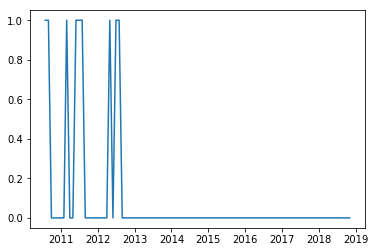

In [27]:
plt.plot(chem_para['ratio_quantity.200313000'])

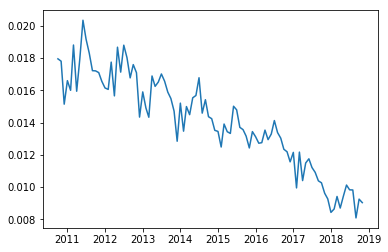

In [17]:
plt.plot(chem_pop['ratio_quantity.200313000'])

In [28]:
chem_para['ratio_quantity.200313000']

month
2010-08-01    1.0
2010-09-01    1.0
2010-10-01    0.0
2010-11-01    0.0
2010-12-01    0.0
2011-01-01    0.0
2011-02-01    0.0
2011-03-01    1.0
2011-04-01    0.0
2011-05-01    0.0
2011-06-01    1.0
2011-07-01    1.0
2011-08-01    1.0
2011-09-01    0.0
2011-10-01    0.0
2011-11-01    0.0
2011-12-01    0.0
2012-01-01    0.0
2012-02-01    0.0
2012-03-01    0.0
2012-04-01    0.0
2012-05-01    1.0
2012-06-01    0.0
2012-07-01    1.0
2012-08-01    1.0
2012-09-01    0.0
2012-10-01    0.0
2012-11-01    0.0
2012-12-01    0.0
2013-01-01    0.0
             ... 
2016-06-01    0.0
2016-07-01    0.0
2016-08-01    0.0
2016-09-01    0.0
2016-10-01    0.0
2016-11-01    0.0
2016-12-01    0.0
2017-01-01    0.0
2017-02-01    0.0
2017-03-01    0.0
2017-04-01    0.0
2017-05-01    0.0
2017-06-01    0.0
2017-07-01    0.0
2017-08-01    0.0
2017-09-01    0.0
2017-10-01    0.0
2017-11-01    0.0
2017-12-01    0.0
2018-01-01    0.0
2018-02-01    0.0
2018-03-01    0.0
2018-04-01    0.0
2018-05-01    0.0
2018

In [24]:
chem_para.loc[chem_para['chemical_code'] == 'ratio_quantity.200313000']

,chemical_code,month,chem_items,para_items,ratio
103659,ratio_quantity.200313000,2010-08-01,1042,1042,1.0
103660,ratio_quantity.200313000,2010-09-01,1067,1067,1.0
103661,ratio_quantity.200313000,2010-10-01,991,991,1.0
103662,ratio_quantity.200313000,2010-11-01,983,983,1.0
103663,ratio_quantity.200313000,2010-12-01,836,836,1.0
103664,ratio_quantity.200313000,2011-01-01,917,917,1.0
103665,ratio_quantity.200313000,2011-02-01,884,884,1.0
103666,ratio_quantity.200313000,2011-03-01,1039,1039,1.0
103667,ratio_quantity.200313000,2011-04-01,881,881,1.0
103668,ratio_quantity.200313000,2011-05-01,990,990,1.0


In [8]:
chem_para_ratio.loc[chem_para_ratio['chemical_code'] == '200313000']

,chemical_code,chemical,para,month,chem_items,para_items
103659,200313000,DUMMY CHEMICAL SUBSTANCE 200313000,DUMMY PARAGRAPH 200313,2010-08-01,1042,1042
103660,200313000,DUMMY CHEMICAL SUBSTANCE 200313000,DUMMY PARAGRAPH 200313,2010-09-01,1067,1067
103661,200313000,DUMMY CHEMICAL SUBSTANCE 200313000,DUMMY PARAGRAPH 200313,2010-10-01,991,991
103662,200313000,DUMMY CHEMICAL SUBSTANCE 200313000,DUMMY PARAGRAPH 200313,2010-11-01,983,983
103663,200313000,DUMMY CHEMICAL SUBSTANCE 200313000,DUMMY PARAGRAPH 200313,2010-12-01,836,836
103664,200313000,DUMMY CHEMICAL SUBSTANCE 200313000,DUMMY PARAGRAPH 200313,2011-01-01,917,917
103665,200313000,DUMMY CHEMICAL SUBSTANCE 200313000,DUMMY PARAGRAPH 200313,2011-02-01,884,884
103666,200313000,DUMMY CHEMICAL SUBSTANCE 200313000,DUMMY PARAGRAPH 200313,2011-03-01,1039,1039
103667,200313000,DUMMY CHEMICAL SUBSTANCE 200313000,DUMMY PARAGRAPH 200313,2011-04-01,881,881
103668,200313000,DUMMY CHEMICAL SUBSTANCE 200313000,DUMMY PARAGRAPH 200313,2011-05-01,990,990


In [75]:
from scipy.special import logit as logit
from scipy.special import expit as expit
chem_para['logit'] = logit(chem_para['ratio'])
chem_para['ratio2'] = expit(chem_para['logit'])
chem_para#.loc[(chem_para['ratio']==0)]

,,ratio,logit,ratio2
month,chemical_code,,,
2016-03-01,ratio_quantity.210200001,0.001375,-6.588221,0.001375
2016-04-01,ratio_quantity.210200001,0.001225,-6.703703,0.001225
2016-05-01,ratio_quantity.210200001,0.001284,-6.656739,0.001284
2016-06-01,ratio_quantity.210200001,0.001211,-6.715310,0.001211
2016-07-01,ratio_quantity.210200001,0.001105,-6.807086,0.001105
2016-08-01,ratio_quantity.210200001,0.001091,-6.819618,0.001091
2016-09-01,ratio_quantity.210200001,0.001022,-6.884770,0.001022
2016-10-01,ratio_quantity.210200001,0.000966,-6.941029,0.000966
2016-11-01,ratio_quantity.210200001,0.001122,-6.791232,0.001122


In [109]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
chem_para_ratio.describe()

,chem_items,para_items
count,225638.00000,225638.00000
mean,37840.09043,503889.28939
std,186159.98886,1062803.26746
min,1.00000,1.00000
25%,47.00000,2110.00000
50%,676.00000,58390.00000
75%,7712.00000,495065.00000
max,5996795.00000,6439718.00000
